## Problem Statement

Learn the following models on XOR dataset (refer to Tensorflow Playground and generate the dataset on your own containing 200 training instances and 200 test instances) such that all these models achieve similar results (good). The definition of good is left subjective – but you would expect the classifier to capture the shape of the XOR function. 
1) a MLP
2) MLP w/ L1 regularization (you may vary the penalty coefficient by choose the best one using a validation dataset)
3) MLP w/ L2 regularization (you may vary the penalty coefficient by choose the best one using a validation dataset)
4) Learn logistic regression models on the same data with additional features (such as x1*x2, x1^2, etc.)<br><br>
Show the decision surface and comment on the plots obtained for different models. [2 marks]

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

import torch
from torch import nn
import torch.nn.functional as F

## Data generation and preparation

In [3]:
def generate_xor(num_samples = 200):
    x = np.random.uniform(low = -1.0, high = 1.0, size = (num_samples, 2))
    x1 = x[:, 0]
    x2 = x[:, 1]
    
    y = np.array((x1 > 0) ^ (x2 > 0)).astype('int32')
    return x, y 

In [4]:
x_data, y_data = generate_xor(num_samples = 1000)
pd.DataFrame(y_data).value_counts()#<-- approximately 50% of the samples need to be y = 1

0
1    507
0    493
Name: count, dtype: int64

In [5]:
x_, x_test, y_, y_test = train_test_split(x_data, y_data, test_size = 0.2)
x_train, x_, y_train, y_ = train_test_split(x_, y_, test_size = 0.75)
_, x_val, _, y_val = train_test_split(x_, y_, test_size = 0.33)

x_train = torch.tensor(x_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
x_test = torch.tensor(x_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)
x_val = torch.tensor(x_val, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)

## Unregularized MLP

In [6]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [7]:
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.Linear(4, 4),
    nn.Linear(4, 4),
    nn.Linear(4, 1) #<-- we will be using logits here
)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
loss_function = nn.BCEWithLogitsLoss()

In [8]:
num_epochs = 250
verbose = 0

for epoch in range(num_epochs):
    model_output = model(x_train)
    # print(model_output)
    loss = loss_function(model_output, y_train.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if verbose:
        if ((epoch + 1)% 25 == 0):
            print(f"Epoch: {epoch + 1} --> Loss: {loss.item()}")

print("---------------------------")
model_pred = model(x_test)
output_labels = (torch.sigmoid(model_pred) > 0.5).float()
print("Accuracy Score -->", end = " ")
print(accuracy_score(y_test, output_labels))
print("---------------------------")

---------------------------
Accuracy Score --> 0.985
---------------------------


## L1 regularized MLP

In [9]:
for coeff in [0.1, 0.01, 0.001, 0.005]:
    model_l1 = nn.Sequential(
        nn.Linear(2, 4),
        nn.ReLU(),
        nn.Linear(4, 4),
        nn.Linear(4, 4),
        nn.Linear(4, 4),
        nn.Linear(4, 1) #<-- we will be using logits here
    )

    def l1_loss(model_output, labels, _lambda):
        loss_func = nn.BCEWithLogitsLoss()
        return loss_func(model_output, labels.unsqueeze(1)) + _lambda * sum(torch.abs(param).sum() for param in model_l1.parameters())

    optimizer = torch.optim.Adam(model_l1.parameters(), lr = 0.01)

    num_epochs = 200
    verbose = 0

    for epoch in range(num_epochs):
        model_output = model_l1(x_train)
        # print(model_output)
        loss = l1_loss(model_output, y_train, coeff)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose:
            if ((epoch + 1)% 25 == 0):
                print(f"Epoch: {epoch + 1} --> Loss: {loss.item()}")

    print("---------------------------")
    print(f"Penalty Coeff --> {coeff}")
    model_pred = model_l1(x_val)
    output_labels = (torch.sigmoid(model_pred) > 0.5).float()
    print("Validation Accuracy Score -->", end = " ")
    print(accuracy_score(y_val, output_labels))

    model_pred = model_l1(x_train)
    output_labels = (torch.sigmoid(model_pred) > 0.5).float()
    print("Train Accuracy Score -->", end = " ")
    print(accuracy_score(y_train, output_labels))
    print("---------------------------")

---------------------------
Penalty Coeff --> 0.1
Validation Accuracy Score --> 0.45454545454545453
Train Accuracy Score --> 0.495
---------------------------
---------------------------
Penalty Coeff --> 0.01
Validation Accuracy Score --> 0.5454545454545454
Train Accuracy Score --> 0.505
---------------------------
---------------------------
Penalty Coeff --> 0.001
Validation Accuracy Score --> 0.5454545454545454
Train Accuracy Score --> 0.505
---------------------------
---------------------------
Penalty Coeff --> 0.005
Validation Accuracy Score --> 0.5454545454545454
Train Accuracy Score --> 0.505
---------------------------


In [25]:
model_l1 = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.Linear(4, 4),
    nn.Linear(4, 4),
    nn.Linear(4, 1) #<-- we will be using logits here
)

def l1_loss(model_output, labels,_lambda):
    loss_func = nn.BCEWithLogitsLoss()
    return loss_func(model_output, labels.unsqueeze(1)) + _lambda * sum(torch.abs(param).sum() for param in model_l1.parameters())

optimizer = torch.optim.Adam(model_l1.parameters(), lr = 0.01)

num_epochs = 300
verbose = 0

for epoch in range(num_epochs):
    model_output = model_l1(x_train)
    # print(model_output)
    loss = l1_loss(model_output, y_train, 0.001)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if verbose:
        if ((epoch + 1)% 25 == 0):
            print(f"Epoch: {epoch + 1} --> Loss: {loss.item()}")

print("---------------------------")
model_pred = model_l1(x_test)
output_labels = (torch.sigmoid(model_pred) > 0.5).float()
print("Test Accuracy Score -->", end = " ")
print(accuracy_score(y_test, output_labels))
print("---------------------------")

---------------------------
Test Accuracy Score --> 0.97
---------------------------


## L2 regularized MLP

In [11]:
for coeff in [0.1, 0.01, 0.001, 0.005]:
    model_l2 = nn.Sequential(
        nn.Linear(2, 4),
        nn.ReLU(),
        nn.Linear(4, 4),
        nn.Linear(4, 1) #<-- we will be using logits here
    )

    def l2_loss(model_output, labels,_lambda):
        loss_func = nn.BCEWithLogitsLoss()
        return loss_func(model_output, labels.unsqueeze(1)) + _lambda * sum(torch.norm(param)**2 for param in model_l2.parameters())

    optimizer = torch.optim.Adam(model_l2.parameters(), lr = 0.01)

    num_epochs = 300
    verbose = 0
    for epoch in range(num_epochs):
        model_output = model_l2(x_train)
        # print(model_output)
        loss = l2_loss(model_output, y_train, coeff)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose:
            if ((epoch + 1)% 25 == 0):
                print(f"Epoch: {epoch + 1} --> Loss: {loss.item()}")

    print("---------------------------")
    print(f"Penalty Coeff --> {coeff}")
    model_pred = model_l2(x_val)
    output_labels = (torch.sigmoid(model_pred) > 0.5).float()
    print("Validation Accuracy Score -->", end = " ")
    print(accuracy_score(y_val, output_labels))

    model_pred = model_l2(x_train)
    output_labels = (torch.sigmoid(model_pred) > 0.5).float()
    print("Train Accuracy Score -->", end = " ")
    print(accuracy_score(y_train, output_labels))
    print("---------------------------")

---------------------------
Penalty Coeff --> 0.1
Validation Accuracy Score --> 0.5454545454545454
Train Accuracy Score --> 0.505
---------------------------
---------------------------
Penalty Coeff --> 0.01
Validation Accuracy Score --> 0.9141414141414141
Train Accuracy Score --> 0.925
---------------------------
---------------------------
Penalty Coeff --> 0.001
Validation Accuracy Score --> 0.8434343434343434
Train Accuracy Score --> 0.86
---------------------------
---------------------------
Penalty Coeff --> 0.005
Validation Accuracy Score --> 0.6717171717171717
Train Accuracy Score --> 0.72
---------------------------


In [29]:
model_l2 = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.Linear(4, 1) #<-- we will be using logits here
)

def l2_loss(model_output, labels,_lambda):
    loss_func = nn.BCEWithLogitsLoss()
    return loss_func(model_output, labels.unsqueeze(1)) + _lambda * sum(torch.norm(param)**2 for param in model_l2.parameters())

optimizer = torch.optim.Adam(model_l2.parameters(), lr = 0.01)

num_epochs = 200
verbose = 0
for epoch in range(num_epochs):
    model_output = model_l2(x_train)
    # print(model_output)
    loss = l2_loss(model_output, y_train, 0.001)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if verbose:
        if ((epoch + 1)% 25 == 0):
            print(f"Epoch: {epoch + 1} --> Loss: {loss.item()}")

print("---------------------------")
model_pred = model_l2(x_test)
output_labels = (torch.sigmoid(model_pred) > 0.5).float()
print("Test Accuracy Score -->", end = " ")
print(accuracy_score(y_test, output_labels))
print("---------------------------")

---------------------------
Test Accuracy Score --> 0.97
---------------------------


## Logistic Regression

In [13]:
x_data.shape

(1000, 2)

In [14]:
def generate_features(x1, x2, n):
    features = [x1, x2, x1*x2]
    # features = [x1, x2, x1*x2, np.sin(x1), np.cos(x1), np.sin(x2), np.cos(x2), x1**2, x2**2, x1**2 * x2, x2**2 * x1, x1**3, x2**3]
    # features = [x1, x2]
    
    # for degree in range(2, n + 1):
    #     features.append(x1 ** degree)
    #     features.append(x2 ** degree)
        
    #     for i in range(1, degree):
    #         features.append((x1 ** i) * (x2 ** (degree - i)))
    
    return np.hstack(features)

In [15]:
# Expanding the feature space
x1 = x_data[:400, 0].reshape(-1, 1)
x2 = x_data[:400, 1].reshape(-1, 1)
y_data = y_data[:400]
# expanded feature space
x_data_new = generate_features(x1, x2, 75)

In [16]:
x1.shape, x2.shape, x_data_new.shape, y_data.shape

((400, 1), (400, 1), (400, 3), (400,))

In [17]:
df = pd.DataFrame(x_data_new)
df.isna().sum(axis = 0).sum(axis = 0) # checking for NaN values

0

In [18]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_data_new, y_data, test_size = 0.4)

In [19]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty = "l1", solver = "liblinear")
lr.fit(x_train2, y_train2)

LogisticRegression(penalty='l1', solver='liblinear')

In [20]:
print("Accuracy score -->", end = " ")
print(accuracy_score(lr.predict(x_test2), y_test2))

Accuracy score --> 0.975


## Decision surface

In [21]:
def plot_decision_surface(model, x_data, y_data, title):
    x_min, x_max = x_data[:, 0].min() - 0.1, x_data[:, 0].max() + 0.1
    y_min, y_max = x_data[:, 1].min() - 0.1, x_data[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    with torch.no_grad():
        Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).numpy()
        Z = (Z > 0).astype(float).flatten()

    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(x_data[:, 0], x_data[:, 1], c=y_data, edgecolors='k', marker='o')
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

In [22]:
def plot_logistic(model, x_data, y_data, title):
    x_min, x_max = -1.1, 1.1
    y_min, y_max = -1.1, 1.1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # print(xx.shape)
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    grid_points_extended = generate_features(grid_points[:, 0].reshape(-1, 1), grid_points[:, 1].reshape(-1, 1), 75)
    # np.column_stack((grid_points, grid_points[:, 0] * grid_points[:, 1], grid_points[:, 0] ** 2, grid_points[:, 1] ** 2, grid_points[:, 0] ** 3, grid_points[:, 1] ** 3))
    Z = model.predict(grid_points_extended)
    # x_plot_data = np.hstack(())

    # Z = model.predict(xx)

    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(x_data[:, 0], x_data[:, 1], c = y_data, edgecolors='k', marker='o')
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

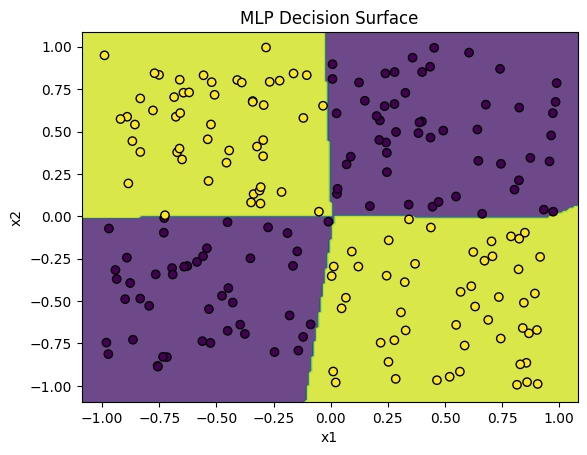

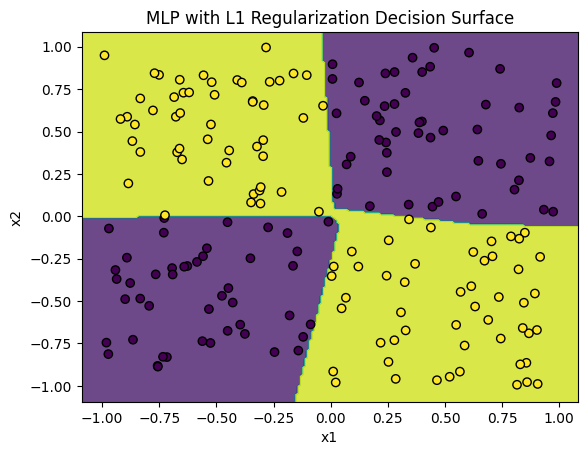

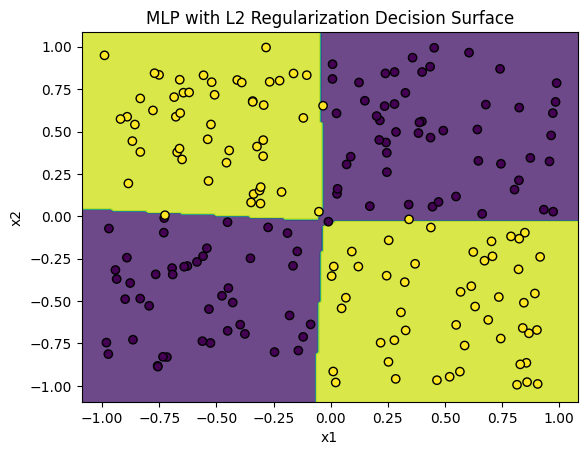

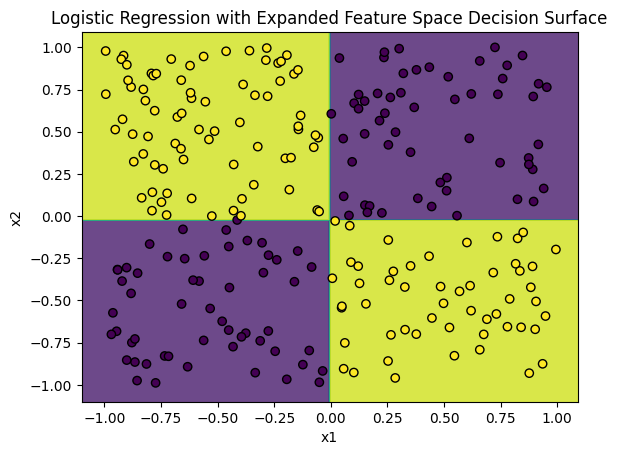

In [30]:
# Plot decision surfaces
plot_decision_surface(model, x_train, y_train, "MLP Decision Surface")
plot_decision_surface(model_l1, x_train, y_train, "MLP with L1 Regularization Decision Surface")
plot_decision_surface(model_l2, x_train, y_train, "MLP with L2 Regularization Decision Surface")
plot_logistic(lr, x_train2, y_train2, "Logistic Regression with Expanded Feature Space Decision Surface")

The decision boundaries for Multi Layer Perceptrons closely resembles with the ideal boundary for a XOR dataset but it has some irregularities, which might be due to the following: <br>
 o sample size is small <br>
 o noise in the data <br>